# [2022 졸업논문팀] GAN 기법을 활용한 탄성파 이미지 해석 (Notebook #3)

## #3. SRGAN 모델

> <b>지도 :</b> 김도완 박사님  
> <b>연구 :</b> 이원석, 여주안, 서민종    

- SRGAN 모델 구조를 만든다
- 모델 학습 확인용 input 데이터셋을 만든다
- SRGAN 모델을 학습시키고 적용해본다

Copyright © 2022 RISE Lab., Juan Yeo

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the “Software”), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED “AS IS”, WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

In [1]:
# 라이브러리 import

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.signal import hilbert
import glob
import tensorflow as tf
from keras.models import Sequential
from keras import layers, Model
from keras.layers import Conv2D, PReLU, BatchNormalization, Flatten
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add

# 1. 모델 구조 만들기

# _

In [3]:
'''
##### GENERATOR BLOCK #####

[input] - [Conv] - [PReLU] -(1)- <Residual> x 5 - [Conv] - [Batch] -(2)- [Add 1,2] - <Upsample> x 2 - [Conv]

<Residual> : -(1)- [Conv] - [Batch] - [PReLU] - [Conv] - [Batch] -(2)- [Add 1,2]
<Upsample> : [Conv] - [PixelShuffer] - [PReLU]
'''

# Conv: k3n64s1
def residual_block(inputs):
    # [Conv] - [Batch] - [PReLU] - [Conv] - [Batch] - [Add]
    model_r = Conv2D(64, (3, 3), padding="same")(inputs)
    model_r = BatchNormalization(momentum=0.5)(model_r)
    model_r = PReLU(shared_axes=[1, 2])(model_r)
    
    model_r = Conv2D(64, (3, 3), padding="same")(model_r)
    model_r = BatchNormalization(momentum=0.5)(model_r)
    
    model_r = add([inputs, model_r])
    return model_r

# Conv: k3n256s1
def upsample_block(inputs):
    # [Conv] - [PixelShuffer 2x] - [PReLU]
    model_u = Conv2D(256, (3, 3), padding="same")(inputs)
    model_u = UpSampling2D(size=2)(model_u)
    model_u = PReLU(shared_axes=[1, 2])(model_u)
    
    return model_u

# Conv: k9n64s1, k3n64s1, k9n3s1
def create_generator(inputs, num_res_block = 5):
    # (input) - [Conv] - [PReLU] - <Residual> x 5 - [Conv] - [Batch] - [Add] - <Upsample> x 2 - [Conv]
    model_g = Conv2D(64, (9, 9), padding="same")(inputs)
    model_g = PReLU(shared_axes=[1, 2])(model_g)
    output_save = model_g
    
    for i in range(num_res_block):
        model_g = residual_block(model_g)
        
    model_g = Conv2D(64, (3, 3), padding="same")(model_g)
    model_g = BatchNormalization(momentum=0.5)(model_g)
    model_g = add([model_g, output_save])
    
    for j in range(2):
        model_g = upsample_block(model_g)
        
    outputs = Conv2D(3, (9, 9), padding="same")(model_g)
    return Model(inputs=inputs, outputs=outputs)

In [4]:
'''
##### DISCRIMINATOR BLOCK #####

[input] - [Conv] - [Leaky ReLU] - <Blue> x 7 - [Dense] - [Leaky ReLU] - [Dense] - [Sigmoid]

<Blue> : [Conv] - [Batch] - [Leaky ReLU] 
* Conv : 64,2 - 128,1 - 128,2 - 256,1 - 256,2 - 512,1 - 512,2  
'''

# Conv: k3n( )s( )
def blue_block(inputs, num_filters, num_strides):
    # [Conv] - [Batch] - [Leaky ReLU]
    model_b = Conv2D(num_filters, (3, 3), strides=num_strides, padding="same")(inputs)
    model_b = BatchNormalization(momentum=0.8)(model_b)
    model_b = LeakyReLU(alpha=0.2)(model_b)
    
    return model_b

# Conv: k3n64s1
def create_discriminator(inputs):
    # (input) - [Conv] - [Leaky ReLU] - <Blue> x 7 - [Dense] - [Leaky ReLU] - [Dense] - [Sigmoid]
    model_d = Conv2D(64, (3, 3), padding="same")(inputs)
    model_d = LeakyReLU(alpha=0.2)(model_d)
    
    model_d = blue_block(model_d, 64, 2)
    model_d = blue_block(model_d, 128, 1)
    model_d = blue_block(model_d, 128, 2)
    model_d = blue_block(model_d, 256, 1)
    model_d = blue_block(model_d, 256, 2)
    model_d = blue_block(model_d, 512, 1)
    model_d = blue_block(model_d, 512, 2)
    # 추출한 특징 1차원으로 변환
    model_d = Flatten()(model_d)
    
    model_d = Dense(1024)(model_d)
    model_d = LeakyReLU(alpha=0.2)(model_d)
    output = Dense(1, activation='sigmoid')(model_d)
    
    return Model(inputs=inputs, outputs=output)

In [7]:
'''
##### VGG19 (CONTENT LOSS) #####

VGG19로 손실을 계산하여 이미지 특성 기반으로 학습합니다. 
'''

from keras.applications.vgg19 import VGG19

def create_feature_extractor(high_resolution_shape):
    vgg = VGG19(weights="imagenet", include_top=False, input_shape=high_resolution_shape)
    
    # block5_conv4_index = 20
    return Model(inputs=vgg.inputs, outputs=vgg.layers[20].output)

In [6]:
'''
##### COMBINED MODEL #####

저해상도 이미지 -> Generator -> 생성된 고해상도 이미지 -> Discriminator / VGG -> 판별 결과 + 생성된 이미지 특성
'''

def create_combined_model(generator, discriminator, vgg, low_resolution_input, high_resolution_input):
    generated_image = generator(low_resolution_input)
    
    generated_image_features = vgg(generated_image)
    
    discriminator.trainable = False
    validity = discriminator(generated_image)
    
    return Model(inputs=[low_resolution_input, high_resolution_input], outputs=[validity, generated_image_features])

# 2. Input Set 만들기

# _

In [8]:
'''
##### IMAGE (Dog, Akita) #####

저해상도 이미지와 고해상도 이미지를 각각 생성한다.
Dog Breed 데이터셋에서 Akita 종의 데이터를 뽑아 작은 이미지 데이터셋를 만들었다.
'''

image_path_list = glob.glob('/content/drive/MyDrive/GraduateThesis/data/004Akita/*.jpg')

high_resolution_images = []
low_resolution_images = []

for path in image_path_list:
    image = cv2.imread(path) 
    
    high_resolution_image = cv2.resize(image, (128, 128))
    low_resolution_image = cv2.resize(image, (32, 32))
    
    high_resolution_image = cv2.cvtColor(high_resolution_image, cv2.COLOR_BGR2RGB)
    high_resolution_images.append(high_resolution_image)
    
    low_resolution_image = cv2.cvtColor(low_resolution_image, cv2.COLOR_BGR2RGB)
    low_resolution_images.append(low_resolution_image)

high_resolution_images = np.array(high_resolution_images)
low_resolution_images = np.array(low_resolution_images)

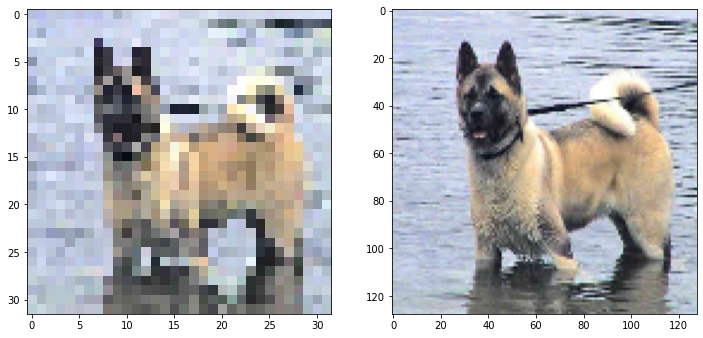

In [9]:
# Input 사진 확인
index = 3

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(low_resolution_images[index], (32, 32, 3)))
plt.subplot(122)
plt.imshow(np.reshape(high_resolution_images[index], (128, 128, 3)))
plt.show()

In [10]:
'''
##### INPUT (Dog, Akita) #####

'''

from sklearn.model_selection import train_test_split

# Image Scaling
high_resolution_images = high_resolution_images / 255.
low_resolution_images = low_resolution_images / 255.

# Train Set, Test Set 분할
low_resolution_train, low_resolution_test, high_resolution_train, high_resolution_test = train_test_split(
    low_resolution_images, high_resolution_images, test_size=0.2, random_state=15)

# Train Set 규모
high_resolution_shape = (high_resolution_train.shape[1], high_resolution_train.shape[2], high_resolution_train.shape[3])
low_resolution_shape = (low_resolution_train.shape[1], low_resolution_train.shape[2], low_resolution_train.shape[3])

# input 생성
high_resolution_input = Input(shape=high_resolution_shape)
low_resolution_input = Input(shape=low_resolution_shape)

# 3. SRGAN 모델 컴파일, Batch 분할

# _

In [31]:
'''
##### MODEL COMPILE #####

'''

# EDIT: number of residual blocks = 5 / 16
generator = create_generator(low_resolution_input, num_res_block=5)

discriminator = create_discriminator(high_resolution_input)
discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])

# EDIT: high resolution shape
vgg = create_feature_extractor(high_resolution_shape = (128, 128, 3))
vgg.trainable = False

srgan_model = create_combined_model(generator, discriminator, vgg, low_resolution_input, high_resolution_input)
srgan_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer="adam")

srgan_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 model_4 (Functional)           (None, 128, 128, 3)  1225539     ['input_2[0][0]']                
                                                                                                  
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_5 (Functional)           (None, 1)            38249281    ['model_4[0][0]']          

In [32]:
'''
##### BATCH SETS #####

'''

# EDIT: batch size
batch_size = 1

low_resolution_batches = []
high_resolution_batches = []
for i in range(int(high_resolution_train.shape[0] / batch_size)):
    start_index = i * batch_size
    end_index = start_index + batch_size
    
    low_resolution_batches.append(low_resolution_train[start_index : end_index])
    high_resolution_batches.append(high_resolution_train[start_index : end_index])

# 4. 모델 학습

# _

In [34]:
'''
##### MODEL TRAINING #####

fake image의 label: 0, real image의 label: 1

'''

from tqdm import tqdm

# EDIT: training epochs
epochs = 15

for e in range(epochs):
    fake_label = np.zeros((batch_size, 1))
    real_label = np.ones((batch_size,1))
     
    g_losses = []
    d_losses = []
    
    # batch 단위로 training 진행 
    for b in tqdm(range(len(high_resolution_batches))):
        low_resolution_images = low_resolution_batches[b] 
        real_images = high_resolution_batches[b] 
        
        fake_images = generator.predict_on_batch(low_resolution_images)
        
        # Discriminator Training 
        discriminator.trainable = True
        d_loss_fake = discriminator.train_on_batch(fake_images, fake_label)
        d_loss_real = discriminator.train_on_batch(real_images, real_label)
        # Generator 학습 위해 Discriminator 학습 제한
        discriminator.trainable = False
        
        # Discriminator Loss 계산 (fake, real 이미지 loss의 평균)
        d_loss = 0.5 * np.add(d_loss_fake, d_loss_real) 
        
        # VGG loss label
        image_features = vgg.predict(real_images)
     
        # Generator Training 
        g_loss, _, _ = srgan_model.train_on_batch([low_resolution_images, real_images], [real_label, image_features])
        
        # Add to loss list 
        d_losses.append(d_loss)
        g_losses.append(g_loss)
           
    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)
    
    # Average Loss
    g_loss = np.sum(g_losses, axis=0) / len(g_losses)
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)
    
    # Report the progress during training. 
    print("epoch: ", e+1 ," generator loss: ", g_loss, " discriminator loss: ", d_loss)

    # EDIT: Save every _ epochs
    if (e+1) % 5 == 0:
        #Save the generator after every n epochs (Usually 10 epochs)
        generator.save("gen_e_"+ str(e+1) +".h5")

100%|██████████| 44/44 [04:11<00:00,  5.71s/it]


epoch:  1  generator loss:  0.17947603660550984  discriminator loss:  [4.87412245 0.85227273]


100%|██████████| 44/44 [04:24<00:00,  6.01s/it]


epoch:  2  generator loss:  0.1481437591666525  discriminator loss:  [6.27904057 0.78409091]


100%|██████████| 44/44 [04:33<00:00,  6.23s/it]


epoch:  3  generator loss:  0.14838345856829124  discriminator loss:  [3.2922985  0.90909091]


100%|██████████| 44/44 [04:17<00:00,  5.85s/it]


epoch:  4  generator loss:  0.14854485169053078  discriminator loss:  [1.65232288 0.875     ]


100%|██████████| 44/44 [04:26<00:00,  6.07s/it]

epoch:  5  generator loss:  0.1064043107696555  discriminator loss:  [1.05269407 0.96590909]



100%|██████████| 44/44 [04:23<00:00,  5.99s/it]


epoch:  6  generator loss:  0.11227796091274782  discriminator loss:  [2.13082369 0.82954545]


100%|██████████| 44/44 [04:26<00:00,  6.05s/it]


epoch:  7  generator loss:  0.09698090770027855  discriminator loss:  [0.3176231  0.95454545]


100%|██████████| 44/44 [04:13<00:00,  5.77s/it]


epoch:  8  generator loss:  0.10001596596769312  discriminator loss:  [2.9850217  0.79545455]


100%|██████████| 44/44 [04:09<00:00,  5.68s/it]


epoch:  9  generator loss:  0.10256520980461077  discriminator loss:  [1.90866291 0.81818182]


100%|██████████| 44/44 [04:10<00:00,  5.69s/it]

epoch:  10  generator loss:  0.09294778989119963  discriminator loss:  [1.81538315 0.78409091]



100%|██████████| 44/44 [04:12<00:00,  5.73s/it]


epoch:  11  generator loss:  0.09296157710592855  discriminator loss:  [2.31810433 0.625     ]


100%|██████████| 44/44 [04:12<00:00,  5.75s/it]


epoch:  12  generator loss:  0.08975203208286654  discriminator loss:  [1.57024366 0.59090909]


100%|██████████| 44/44 [04:14<00:00,  5.78s/it]


epoch:  13  generator loss:  0.0880003170194951  discriminator loss:  [0.85191358 0.72727273]


100%|██████████| 44/44 [04:13<00:00,  5.77s/it]


epoch:  14  generator loss:  0.08510235214436596  discriminator loss:  [1.2457776  0.70454545]


100%|██████████| 44/44 [04:12<00:00,  5.73s/it]

epoch:  15  generator loss:  0.08434682330963286  discriminator loss:  [0.84916908 0.79545455]


# 5. 모델 테스트

# _

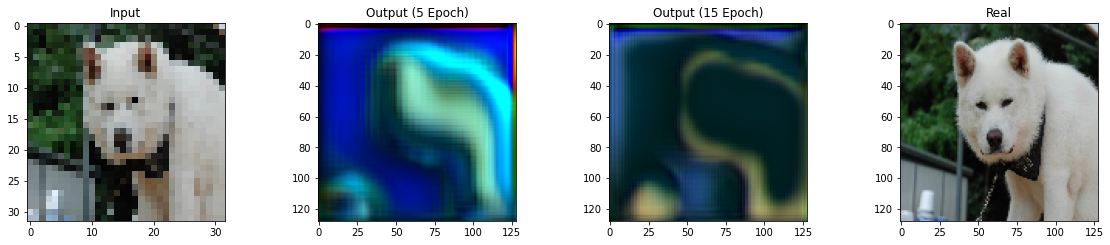

In [35]:
'''
##### MODEL TEST #####

'''

from keras.models import load_model

# EDIT: test index
test_index = 8

trained_generator_5 = load_model('gen_e_5.h5', compile=False)
trained_generator = load_model('gen_e_15.h5', compile=False)

source_image = low_resolution_test[test_index]
source_image = np.array([source_image])
real_image = high_resolution_test[test_index]
real_image = np.array([real_image])

generated_image_5 = trained_generator_5.predict(source_image)
generated_image = trained_generator.predict(source_image)

plt.figure(figsize=(20, 8))
plt.subplot(241)
plt.title('Input')
plt.imshow(source_image[0,:,:,:])
plt.subplot(242)
plt.title('Output (5 Epoch)')
plt.imshow(generated_image_5[0,:,:,:])
plt.subplot(243)
plt.title('Output (15 Epoch)')
plt.imshow(generated_image[0,:,:,:])
plt.subplot(244)
plt.title('Real')
plt.imshow(real_image[0,:,:,:])

plt.show()